In [1]:
%cd ..

/home/dawood/Workspace/compoundGAN


In [2]:
import os
import sys

import torch
import joypy
import dgl
import random
import networkx as nx
import numpy as np

from tqdm.notebook import tqdm 
from collections import defaultdict

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import RDConfig
from rdkit.Chem import QED
from rdkit.Chem import AllChem

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

import selfies
from selfies import encoder as selfies_encoder
from selfies import decoder as selfies_decoder
from data.selfies import SELFIES, SELFIE_VOCAB, SELFIES_STEREO
from data.zinc import ZINC250K

from models.network import CVAEF

from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
import umap
from cvae import cvae


from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

DEVICE = torch.device('cuda:0')

random.seed(42)

In [3]:
state_dict = torch.load('/home/dawood/Experiments/compound-gan-93ace7ef2b534631aa1b885257bc1f0c/model_196.weights', map_location='cpu')
seq_len = 300

In [4]:
D = 256
L = D
C = 1
DIM_TOKEN = 139
model = CVAEF([DIM_TOKEN, 3], D,
              [L, L, L, L], C, 0.9, True, use_adjoint=False, num_decoder_layers=4)
model.load_state_dict(state_dict['parameters'])
model = model.eval().to(DEVICE)

In [5]:
def pred2smiles(x):
    seq = []
    iterator = zip(x[:, :DIM_TOKEN].argmax(-1).long().tolist(), x[:, DIM_TOKEN:].argmax(-1).long().tolist())
    for n, (i, j) in enumerate(iterator):
        t = SELFIE_VOCAB[i]
        s = SELFIES_STEREO[j]

        if i != 0 and i != 1:
            t = '[' + s + t[1:]

        seq.append(t)

        if i == 1:
            break
        
    selfie = ''.join(seq)
    smiles = selfies.decoder(selfie.replace('[START]', '').replace('[END]', ''))
    
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        Chem.SanitizeMol(mol, catchErrors=False)
        smiles = Chem.MolToSmiles(mol)
    except Exception as e:
        print('MOL ERROR : ', e)
        return '', None, False

    try:
        AllChem.AssignAtomChiralTagsFromStructure(mol,confId=-1,replaceExistingTags=True)
        is_3d_valid = AllChem.EmbedMolecule(mol, useExpTorsionAnglePrefs=True, useBasicKnowledge=True, useRandomCoords=True)        
        AllChem.MMFFOptimizeMolecule(mol)
        is_3d_valid = True
    except Exception as e:
        print('MOL ERROR : 3D Invalid ', e)
        is_3d_valid = False
        
    return smiles, mol, is_3d_valid

def generate_random(num_mols, draw=True):

    B = 32
    
    pred_smiles = []
    pred_mols   = []
    
    logp_data = []
    qed_data  = []
    sas_data  = []
    tpsa_data = []

    for i in tqdm(range(num_mols//B)):
        z = torch.zeros((B, D - C))
        condition = torch.zeros((B, C))
        condition.uniform_(0, 1)
        for j in range(len(z)):
            z[j].normal_(0, 1)
            if C > 0:
                condition[j, 0] = ((condition[j, 0] - 0.5) * 12).int().float()
                # # tpsa
                # condition[j, 1] = ((condition[j, 1] * 15).int().float())
                # # qed
                # condition[j, 1] = ((condition[j, 1] * 10).int().float())
                # # sas
                # condition[j, 2] = ((condition[j, 2] * 10).int().float())

        z = torch.cat([z, condition], -1)
        z = z.to(DEVICE)
        
        z = model.cnf(z, None, True)[0]
        pred = model.decoder.generate(z, seq_len)
        
        for b in range(pred.shape[1]):
            smiles, mol = pred2smiles(pred[:, b])

            if mol is not None:
                pred_mols.append(mol)
                pred_smiles.append(Chem.CanonSmiles(Chem.MolToSmiles(mol)))
                
                pred_logp = Chem.Descriptors.MolLogP(mol)
                # pred_qed  = QED.qed(mol)
                # pred_sas  = sascorer.calculateScore(mol)
                # pred_tpsa = Chem.Descriptors.TPSA(mol, includeSandP=True)  
                
                if C > 0:
                    logp_data.append((condition[b, 0].item(), pred_logp))
                    # tpsa_data.append((condition[b, 1].item() * 10, pred_tpsa))
                    # qed_data.append((condition[b, 1].item() / 10, pred_qed))
                    # sas_data.append((condition[b, 2].item(), pred_sas))
    
    num_mols = len(pred_mols)

    if draw:
        img = Draw.MolsToGridImage(pred_mols, molsPerRow=4, subImgSize=(400, 400))
        plt.figure(figsize=(num_mols*2, num_mols*2))
        plt.imshow(img, interpolation='bilinear')
        plt.axis('off')
        plt.show()

In [6]:
def generate_latentspace_info(num_mols = 1000, batch_size = 32, max_seq_len = 300):
    
    data = []
    
    for i in tqdm(range(num_mols//batch_size)):
        
        # draw Z from Gaussian
        z = torch.zeros((batch_size, D  - C))
        z.normal_(0, 1)
        
        if C > 0:
            condition = torch.zeros((batch_size, C))
            condition.uniform_(0, 1)
            for j in range(batch_size):
                condition[j, 0] = ((condition[j, 0] - 0.5) * 12).int().float()
            z = torch.cat([z, condition], dim=1)
        
        z = z.to(DEVICE)
        
        # W = CNF^-1(Z)
        w = model.cnf(z, None, True)[0]
        
        # Predict
        pred = model.decoder.generate(z, max_seq_len)

        for b in range(batch_size):
            smiles, mol, is_3d_valid = pred2smiles(pred[:, b])
            if mol is not None:
                logP_data = Chem.Descriptors.MolLogP(mol)
                
            data.append({
                'smiles': smiles,
                'mol': mol,
                'is_3d_valid': is_3d_valid,
                'z': z[b].data.cpu().numpy(),
                'w': w[b].data.cpu().numpy(),
                'logP': logP_data
            })
        
    return data

In [21]:
data = generate_latentspace_info(1000, 64, 300)

MOL ERROR : 3D Invalid  Invariant Violation
	Cannot be a chiral center
	Violation occurred on line 684 in file Code/GraphMol/DistGeomHelpers/Embedder.cpp
	Failed Expression: nbrs.size() >= 3
	RDKIT: 2019.03.4
	BOOST: 1_67

MOL ERROR :  Sanitization error: Explicit valence for atom # 23 O, 3, is greater than permitted
MOL ERROR :  Sanitization error: Explicit valence for atom # 21 N, 5, is greater than permitted
MOL ERROR : 3D Invalid  Bad Conformer Id
MOL ERROR : 3D Invalid  Sanitization error: Can't kekulize mol.  Unkekulized atoms: 12 13 17 18 19

MOL ERROR : 3D Invalid  Invariant Violation
	Cannot be a chiral center
	Violation occurred on line 684 in file Code/GraphMol/DistGeomHelpers/Embedder.cpp
	Failed Expression: nbrs.size() >= 3
	RDKIT: 2019.03.4
	BOOST: 1_67

MOL ERROR :  Sanitization error: Explicit valence for atom # 19 N, 4, is greater than permitted
MOL ERROR :  Sanitization error: Explicit valence for atom # 22 O, 4, is greater than permitted
MOL ERROR :  Sanitization err

In [22]:
z_data = np.array([d['z'] for d in data])
w_data = np.array([d['w'] for d in data])

In [23]:
reducer = cvae.CompressionVAE(z_data, train_valid_split=0.7)
reducer.train()
z_emb = reducer.embed(z_data)

Total amount of data:  672
Input feature dimension:  256
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  288
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.
Session set up.
Trying to restore saved checkpoints from /home/dawood/Workspace/compoundGAN/temp ... No checkpoint found.
No model found to restore. Initialising new model.
Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 129.597, test_loss = 130.117, lr = 0.00100, (0.016 sec/step)
Storing checkpoint to /home/dawood/Workspace/compoundGAN/temp ... Done.
step 50; epoch 4.76 - loss = 125.713, test_loss = 128.115, lr = 0.00100, (0.001 sec/step)
step 100; epoch 9.52 - loss = 128.879, test_loss = 128.146, lr = 0.00100, (0.001 sec/step)
step 150; epoch 14.29 - loss = 128.881, test_loss = 128.018, lr = 0.00100, (0.001 sec/step)
step 200; epoch 19.05 - loss = 127.783, test_loss = 128.087, lr = 0.00100, (0.001 sec/step)
step 250; epoch 23.81 - lo

In [24]:
reducer = cvae.CompressionVAE(w_data)
reducer.train()
w_emb = reducer.embed(w_data)

Total amount of data:  864
Input feature dimension:  256
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  96
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.
Session set up.
Trying to restore saved checkpoints from /home/dawood/Workspace/compoundGAN/temp ... No checkpoint found.
No model found to restore. Initialising new model.
Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 127.741, test_loss = 126.729, lr = 0.00100, (0.018 sec/step)
Storing checkpoint to /home/dawood/Workspace/compoundGAN/temp ... Done.
step 50; epoch 3.70 - loss = 129.770, test_loss = 125.233, lr = 0.00100, (0.001 sec/step)
step 100; epoch 7.41 - loss = 126.948, test_loss = 125.011, lr = 0.00100, (0.000 sec/step)
step 150; epoch 11.11 - loss = 129.767, test_loss = 124.930, lr = 0.00100, (0.001 sec/step)
step 200; epoch 14.81 - loss = 128.386, test_loss = 124.961, lr = 0.00100, (0.000 sec/step)
step 250; epoch 18.52 - los

<Figure size 432x288 with 0 Axes>

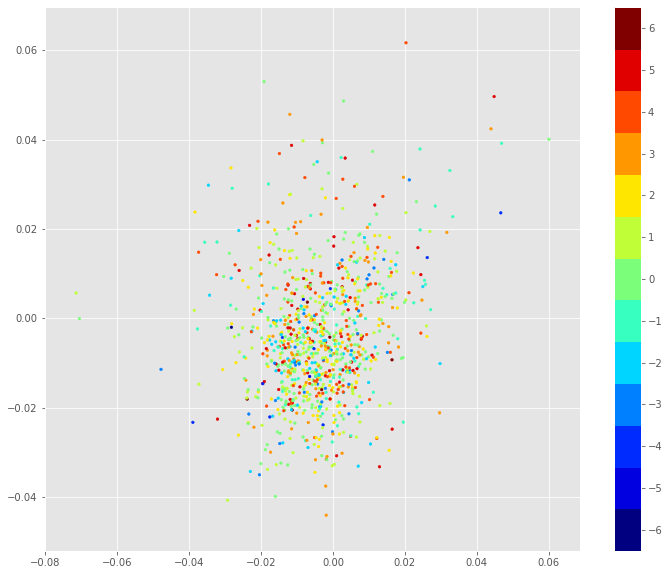

<Figure size 432x288 with 0 Axes>

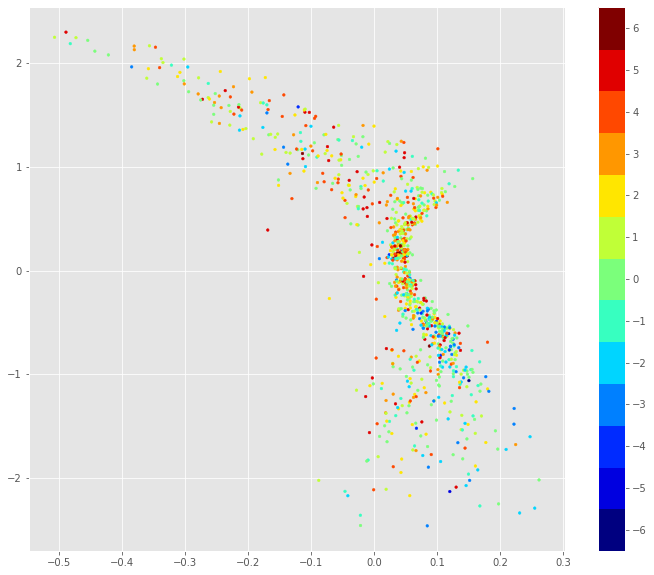

In [27]:
labels = [int(d['logP']) for d in data]
plt.figure()
reducer.visualize(z_emb, labels=labels)
plt.figure()
reducer.visualize(w_emb, labels=labels)
plt.show()

<Figure size 432x288 with 0 Axes>

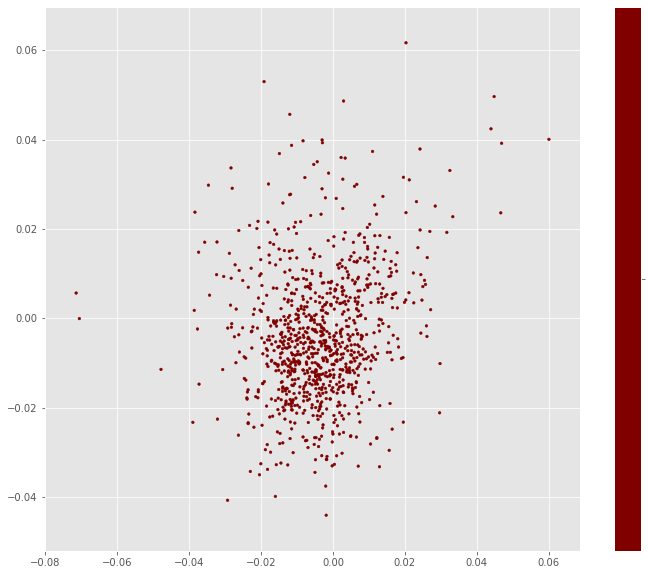

<Figure size 432x288 with 0 Axes>

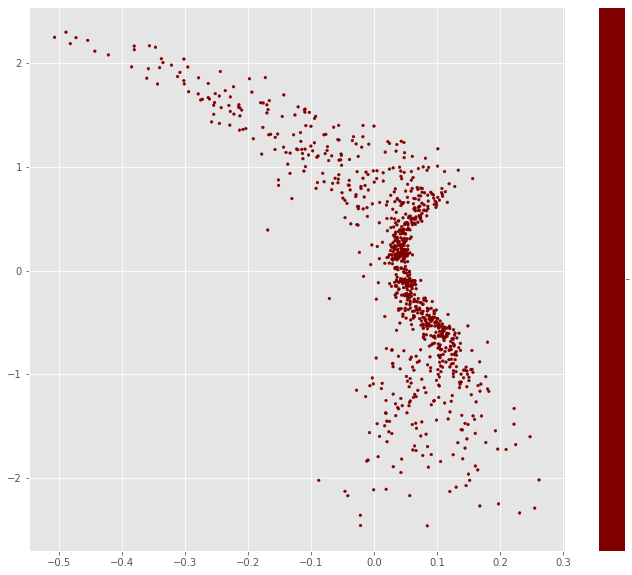

In [45]:
labels=['' for _ in data]
plt.figure()
reducer.visualize(z_emb, labels)
plt.figure()
reducer.visualize(w_emb, labels)
plt.show()